In [1]:
from som_vae.settings.config import SetupConfig
# adapt according to your machine (0 should be fine, if you have a GPU)
if SetupConfig.runs_on_lab_server():
    %env CUDA_DEVICE_ORDER=PCI_BUS_ID
    %env CUDA_VISIBLE_DEVICES=1

# VAE using the reparametrization trick

## Imports and enabling of eager execution

In [2]:
import json
from collections import namedtuple
from functools import partial
import itertools
import warnings
import os
import time
import numpy as np
import pandas as pd
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import PIL
import imageio
from IPython import display
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.manifold import TSNE
from functional import seq
from pathlib import Path
from functools import reduce

from importlib import reload # for debugging and developing, optional

import tensorflow as tf
import tensorflow.contrib as tfc
import tensorflow.contrib.eager as tfe
import tensorflow.keras as tfk
import tensorflow.keras.layers as tfkl
import tensorflow_probability as tfp

# for the KL-loss explosion problem
tf.enable_eager_execution()
# we currently handle them ourselves. but with this, it will throw an error before we can apply the fix
tfe.seterr(inf_or_nan='raise')

# otherwise TF will print soooo many warnings
warnings.filterwarnings('ignore', '.*FutureWarning.*np.complexfloating.*')

from som_vae.helpers.tensorflow import _TF_DEFAULT_SESSION_CONFIG_
import som_vae.helpers.tensorflow as tf_helpers
sess = tf.InteractiveSession(config=_TF_DEFAULT_SESSION_CONFIG_)
tf.keras.backend.set_session(sess)

from som_vae.settings.config import SetupConfig, RunConfig
from som_vae import data_loading
from som_vae import settings
from som_vae import preprocessing
from som_vae.helpers.misc import extract_args, chunks, foldl, if_last
from som_vae.helpers.jupyter import fix_layout, display_video
from som_vae.settings import config, skeleton
from som_vae.settings import data as SD
from som_vae.helpers import video, plots, misc, jupyter
from som_vae import preprocessing
from som_vae.helpers.logging import enable_logging

W0613 22:29:37.071381 140180185089856 deprecation_wrapper.py:119] From /home/sam/proj/epfl/neural_clustering_vae/som_vae/helpers/tensorflow.py:7: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.



In [3]:
jupyter.fix_layout()

# Setup, loading of data

In [4]:
setup_cfg = SetupConfig()
run_cfg = RunConfig()

frame_data, frame_labels, normalisation_factors = data_loading.load_labelled_data(run_config=run_cfg, setup_config=setup_cfg)

W0613 22:29:37.229051 140180185089856 preprocessing.py:73] this works only for the first legs!
W0613 22:29:37.232380 140180185089856 preprocessing.py:73] this works only for the first legs!
W0613 22:29:37.235548 140180185089856 preprocessing.py:73] this works only for the first legs!
W0613 22:29:37.238706 140180185089856 preprocessing.py:73] this works only for the first legs!
W0613 22:29:37.242055 140180185089856 preprocessing.py:73] this works only for the first legs!
W0613 22:29:37.245349 140180185089856 preprocessing.py:73] this works only for the first legs!
W0613 22:29:37.248421 140180185089856 preprocessing.py:73] this works only for the first legs!
W0613 22:29:37.251604 140180185089856 preprocessing.py:73] this works only for the first legs!
W0613 22:29:37.254761 140180185089856 preprocessing.py:73] this works only for the first legs!
W0613 22:29:37.257948 140180185089856 preprocessing.py:73] this works only for the first legs!
W0613 22:29:37.261563 140180185089856 preprocessin

huh?? something odd with Experiment(study_id='180921_aDN_CsCh', fly_id='Fly3', experiment_id='001_SG1'): /home/sam/proj/epfl/neural_clustering_data/experiments/180921_aDN_CsCh/Fly3/001_SG1/behData/images: [Errno 2] No such file or directory: '/home/sam/proj/epfl/neural_clustering_data/experiments/180921_aDN_CsCh/Fly3/001_SG1/behData/images'
huh?? something odd with Experiment(study_id='180921_aDN_CsCh', fly_id='Fly6', experiment_id='001_SG1'): /home/sam/proj/epfl/neural_clustering_data/experiments/180921_aDN_CsCh/Fly6/001_SG1/behData/images: [Errno 2] No such file or directory: '/home/sam/proj/epfl/neural_clustering_data/experiments/180921_aDN_CsCh/Fly6/001_SG1/behData/images'
huh?? something odd with Experiment(study_id='180921_aDN_CsCh', fly_id='Fly4', experiment_id='003_SG1'): /home/sam/proj/epfl/neural_clustering_data/experiments/180921_aDN_CsCh/Fly4/003_SG1/behData/images: [Errno 2] No such file or directory: '/home/sam/proj/epfl/neural_clustering_data/experiments/180921_aDN_CsCh/

# preprocessing

In [5]:
def to_int_value(frame_with_label):
    return np.array([l.label.value for l in frame_with_label[:,1]])

In [6]:
if run_cfg['data_type'] == config.DataType.ANGLE_3D:
    frame_data, frame_labels, selected_columns, normalisation_factors = preprocessing.preprocess_angle_3d_data(
        frame_data, frame_labels, **run_cfg.value('angle_3d_params', 'preprocessing'))
if run_cfg['data_type'] == config.DataType.POS_2D:
    selected_columns = None
    frame_data, frame_labels = preprocessing.preprocess_pos_2d_data(frame_data, frame_labels)

In [7]:
scaler = StandardScaler()

n_train_data_points = int(frame_data.shape[0] * run_cfg['train_test_ratio'])

X_train = scaler.fit_transform(frame_data[:n_train_data_points])
X_test = scaler.transform(frame_data[n_train_data_points:])
y_train = to_int_value(frame_labels[:n_train_data_points])
y_test = to_int_value(frame_labels[n_train_data_points:])
frame_labels_train = frame_labels[:n_train_data_points]
frame_labels_test = frame_labels[n_train_data_points:]

if run_cfg['use_time_series']:
    X_train, X_test, y_train, y_test, frame_labels_train, frame_labels_test = [misc.to_time_series_np(x, sequence_length=run_cfg['time_series_length']) 
                                        for x in (X_train, X_test, y_train, y_test, frame_labels_train, frame_labels_test)]

In [8]:
##
## debugging overwrite
##
#    
#if run_config['debug']:
#    if run_config['d_zero_data']:
#        # resetting the scaler to make our life easier down below the pipeline
#        _dummy_data_ = np.zeros_like(joint_positions)
#    elif run_config['d_sinoid_data']:
#        if run_config['data_type'] == _DATA_TYPE_2D_POS_:
#            _dummy_data_ = np.zeros_like(joint_positions)
#            for frame in range(_dummy_data_.shape[0]):
#                for joint in range(_dummy_data_.shape[1]):
#                    _dummy_data_[frame, joint, :] = np.sin(2 * np.pi * frame/_dummy_data_.shape[0] + joint / _dummy_data_.shape[1])
#                
#        else:
#            _dummy_data_ = np.array([[np.sin(x) + (offset / joint_positions.shape[1]) 
#                                      for x in range(len(joint_positions))] 
#                                     for offset in range(joint_positions.shape[1])]).T.astype(joint_positions.dtype)
#    elif run_config['d_sinoid_cluster_data']:
#        if run_config['data_type'] == _DATA_TYPE_2D_POS_:
#            raise NotImplementedError
#        else:
#            _dummy_data_ = np.zeros_like(joint_positions)
#            _dummy_labels_ = np.zeros(joint_positions.shape[0])
#            for c in range(_dummy_data_.shape[1]):
#                _dummy_data_[:, c], _dummy_labels_ = dummy_data_complex_sine_like(_dummy_data_.shape[0])
#            
#    if run_config['data_type'] == _DATA_TYPE_2D_POS_:
#        _dummy_data_ = misc.prep_2d_pos_data(_dummy_data_)
#        
#    if run_config['use_time_series']:
#        reshaped_joint_position = scaler.fit_transform(_dummy_data_)
#        reshaped_joint_position = misc.to_time_series_np(reshaped_joint_position, sequence_length=run_config['time_series_length'])
#        labels = _dummy_labels_[run_config['time_series_length'] - 1:]
#    else:
#        reshaped_joint_position = _dummy_data_
#        labels = _dummy_labels_

In [9]:
run_cfg.description(short=True)

'SKIP_PADD_CONV-POS_2D-t-16-ld-8'

In [10]:
reload(plots)
#
# Making sure that the train/test distributions are not too different from each other
#
    
#if run_cfg['data_type'] == data_loading.DataType.ANGLE_3D:
#    fig = plots.plot_3d_angle_data_distribution(X_train[_plt_data_idx_],
#                                                X_test[_plt_data_idx_],
#                                                selected_columns, 
#                                                exp_desc=run_cfg.description())
#else:
#    fig = plots.plot_2d_distribution(data_train[_plt_data_idx_], data_test[_plt_data_idx_], exp_desc=run_config.description())

<module 'som_vae.helpers.plots' from '/home/sam/proj/epfl/neural_clustering_vae/som_vae/helpers/plots.py'>

# model def

## doc

### Sources:

- https://blog.keras.io/building-autoencoders-in-keras.html (keras autoencoder implementation)
- https://medium.com/the-artificial-impostor/notes-understanding-tensorflow-part-3-7f6633fcc7c7 (temporal block)
- https://stackoverflow.com/questions/46503816/keras-conv1d-layer-parameters-filters-and-kernel-size (refresher on conv layers)
- https://towardsdatascience.com/types-of-convolutions-in-deep-learning-717013397f4d (refresher on conv layers)
- https://jeddy92.github.io/JEddy92.github.io/ts_seq2seq_conv/ (for a good overview over diluted causal convolutions)
- https://blog.goodaudience.com/introduction-to-1d-convolutional-neural-networks-in-keras-for-time-sequences-3a7ff801a2cf?gi=c5cb3c007035 (general reference)
- https://medium.com/tensorflow/variational-autoencoders-with-tensorflow-probability-layers-d06c658931b7 (VAE with tensorflow probability)

### Generative Network
This defines the generative model which takes a latent encoding as input, and outputs the parameters for a conditional distribution of the observation, i.e. $p(x|z)$. Additionally, we use a unit Gaussian prior $p(z)$ for the latent variable.

### Inference Network
This defines an approximate posterior distribution $q(z|x)$, which takes as input an observation and outputs a set of parameters for the conditional distribution of the latent representation. In this example, we simply model this distribution as a diagonal Gaussian. In this case, the inference network outputs the mean and log-variance parameters of a factorized Gaussian (log-variance instead of the variance directly is for numerical stability).

### Reparameterization Trick
During optimization, we can sample from $q(z|x)$ by first sampling from a unit Gaussian, and then multiplying by the standard deviation and adding the mean. This ensures the gradients could pass through the sample to the inference network parameters.

### Network architecture
For the inference network, we use two convolutional layers followed by a fully-connected layer. In the generative network, we mirror this architecture by using a fully-connected layer followed by three convolution transpose layers (a.k.a. deconvolutional layers in some contexts). Note, it's common practice to avoid using batch normalization when training VAEs, since the additional stochasticity due to using mini-batches may aggravate instability on top of the stochasticity from sampling.

The dilated convolution between signal $f$ and kernel $k$ and dilution factor $l$ is defined as:

$$\left(k \ast_{l} f\right)_t = \sum_{\tau=-\infty}^{\infty} k_\tau \cdot f_{t - l\tau}$$

![](./figures/diluted_convolution.png)
![](./figures/WaveNet_gif.gif)

VAEs train by maximizing the evidence lower bound (ELBO) on the marginal log-likelihood:

$$\log p(x) \ge \text{ELBO} = \mathbb{E}_{q(z|x)}\left[\log \frac{p(x, z)}{q(z|x)}\right].$$

In practice, we optimize the single sample Monte Carlo estimate of this expectation:

$$\log p(x| z) + \log p(z) - \log q(z|x),$$
where $z$ is sampled from $q(z|x)$.

**Note**: we could also analytically compute the KL term, but here we incorporate all three terms in the Monte Carlo estimator for simplicity.

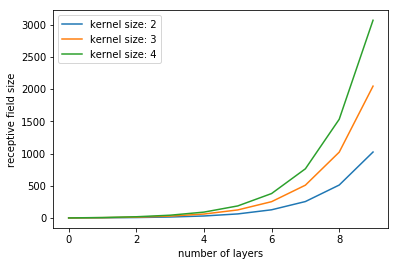

In [11]:
def _receptive_field_size_temporal_conv_net_(kernel_size, n_layers):
    return 1 + 2 * (kernel_size - 1) * (2 ** n_layers - 1)

for k in range(2, 5):
    plt.plot([_receptive_field_size_temporal_conv_net_(kernel_size=k, n_layers=n) for n in range(10)], label=f"kernel size: {k}")
plt.xlabel('number of layers')
plt.ylabel('receptive field size')
plt.legend()

## training

In [12]:
from som_vae.helpers.tensorflow import to_tf_data

from som_vae.training import vae as vae_training
from som_vae.training import supervised as supervised_training

reload(vae_training)
reload(supervised_training)

<module 'som_vae.training.supervised' from '/home/sam/proj/epfl/neural_clustering_vae/som_vae/training/supervised.py'>

In [13]:
def _reshape_and_rescale_(X, scaler=scaler, data_type=run_cfg['data_type']):
    """To be defined in this notebook / function. Basically a larger lambda function
    """
    rescaled = scaler.inverse_transform(X)
    if data_type ==  config.DataType.POS_2D:
        return rescaled.reshape(-1, 15, 2)
    elif data_type ==  config.DataType.ANGLE_3D:
        return rescaled
    else:
        raise ValueError(f"uh, got something odd: {data_type}")

In [14]:
from hdbscan import HDBSCAN
from collections import namedtuple
from sklearn.manifold import TSNE

LatentSpaceEncoding = namedtuple('LatentSpaceEncoding', 'mean var')

In [15]:
def get_latent_space(model, X):
    if model._name in ['drosoph_vae_conv', 'drosoph_vae_skip_conv']:
        return LatentSpaceEncoding(*map(lambda x: x.numpy(), model.encode(X)))
    else:
        return LatentSpaceEncoding(*map(lambda x: x.numpy()[back_to_single_time], model.encode(X)))

from matplotlib import gridspec

def plot_latent_space(X_latent, X_latent_mean_tsne_proj, y, cluster_assignments, run_desc, epochs):
    cluster_colors = sns.color_palette(n_colors=len(np.unique(cluster_assignments)))
    fig = plt.figure(figsize=(20, 18))
    gs = gridspec.GridSpec(3, 2, figure=fig)
    ax1 = plt.subplot(gs[:2, :])
    ax2 = plt.subplot(gs[-1:, :1])
    ax3 = plt.subplot(gs[-1:, 1:])

    plot_data = pd.DataFrame(X_latent_mean_tsne_proj, columns=['latent_0', 'latent_1'])
    plot_data['Cluster'] = cluster_assignments
    plot_data['Class'] = y
    plot_data['mean_0'], plot_data['mean_1'] = X_latent.mean[:, 0], X_latent.mean[:, 1]
    plot_data['var_0'], plot_data['var_1'] = X_latent.var[:, 0], X_latent.var[:, 1]

    sns.scatterplot(data=plot_data, x='latent_0', y='latent_1', style='Class', hue='Cluster', ax=ax1, palette=cluster_colors)
    sns.scatterplot(data=plot_data, x='mean_0', y='mean_1', style='Class', hue='Cluster', ax=ax2, palette=cluster_colors)
    sns.scatterplot(data=plot_data, x='var_0', y='var_1', style='Class', hue='Cluster', ax=ax3, palette=cluster_colors)

    ax1.set_title('T-SNE projection of latent space (mean & var stacked)')
    ax2.set_title('mean')
    ax3.set_title('var')
    figure_path = f"{SetupConfig.value('figures_root_path')}/{run_desc}_e-{epochs}_latent_space_tsne.png"
    plt.savefig(figure_path)
    return figure_path

In [16]:
import pickle
def dump_results(results, config_desc):
    misc.create_parents(f"{SetupConfig.value('grid_search_root_path')}/{config_desc}.pkl")
    with open(f"{SetupConfig.value('grid_search_root_path')}/{config_desc}.pkl", 'wb') as f:
        pickle.dump(results, f)

In [17]:
from som_vae.losses import purity as P

In [50]:
def _equalize_ylim(ax0, ax1):
    ymin0, ymax0 = ax0.get_ylim()
    ymin1, ymax1 = ax1.get_ylim()
    
    min_ = min(ymin0, ymin1)
    max_ = max(ymax0, ymax1)
    
    ax0.set_ylim((min_, max_))
    ax1.set_ylim((min_, max_))

In [55]:
def plot_reconstruction_comparision_pos_2d(real, reconstructed, run_desc, epochs):
    fig, axs = plt.subplots(3 * 2, real.shape[2], sharex=True, figsize=(25, 10))
    
    x_axis_values = np.arange(real.shape[0]) / SetupConfig.value('frames_per_second') / 60.

    for dim in range(2):
        for leg in range(3):
            for limb in range(5):
                axs[2 * leg][dim].plot(x_axis_values, real[:, limb + leg * 5, dim])
                axs[2 * leg + 1][dim].plot(x_axis_values, reconstructed[:, limb + leg * 5, dim])
                
    axs[0][0].set_title('x')
    axs[0][1].set_title('y')

    for leg in range(3):
        axs[2*leg][0].set_ylabel(f"input\n{plots._get_leg_name_(leg)}")
        axs[2*leg + 1][0].set_ylabel(f"reconstructed\n{plots._get_leg_name_(leg)}")

        axs[2*leg][0].get_shared_y_axes().join(axs[2*leg][0], axs[2*leg + 1][0])
        axs[2*leg][1].get_shared_y_axes().join(axs[2*leg][1], axs[2*leg + 1][1])
        
        _equalize_ylim(axs[2 * leg][dim], axs[2 * leg + 1][dim])
        
        #axs[2*leg][1].set_yticks([])
        #axs[2*leg + 1][1].set_yticks([])
        
    axs[-1][0].set_xlabel('time [min]')
    axs[-1][1].set_xlabel('time [min]')

    fig.align_ylabels(axs)
    fig.suptitle(f"Comparing input and reconstruction")
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    figure_path = f"{SetupConfig.value('figures_root_path')}/{run_desc}_e-{epochs}_input_gen_recon_comparision.png"
    plt.savefig(figure_path)
    return figure_path

In [19]:
def plot_reconstruction_comparision_angle_3d(X_eval, X_hat_eval, epochs, selected_columns=selected_columns, run_desc=None):
    xticks = np.arange(0, len(X_eval)) / SetupConfig.value('frames_per_second') / 60.
    fig, axs = plt.subplots(nrows=X_eval.shape[1], ncols=1, figsize=(20, 30), sharex=True, sharey=True)
    for i, cn in enumerate(data_loading.get_3d_columns_names(selected_columns)):
        _idx_ = np.s_[:, i]
        axs[i].plot(xticks, X_eval[_idx_], label='input')
        axs[i].plot(xticks, X_hat_eval[_idx_], label='reconstructed')

        axs[i].set_title(cn)

    axs[-1].set_xlabel('time [min]')
    axs[0].legend(loc='upper left')
    
    #plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.suptitle(f"Comparision of selection of data\n({run_desc}_e-{epochs})")
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.94)
    figure_path = f"{SetupConfig.value('figures_root_path')}/{run_desc}_e-{epochs}_input_gen_recon_comparision.png"
    plt.savefig(figure_path)
    return figure_path

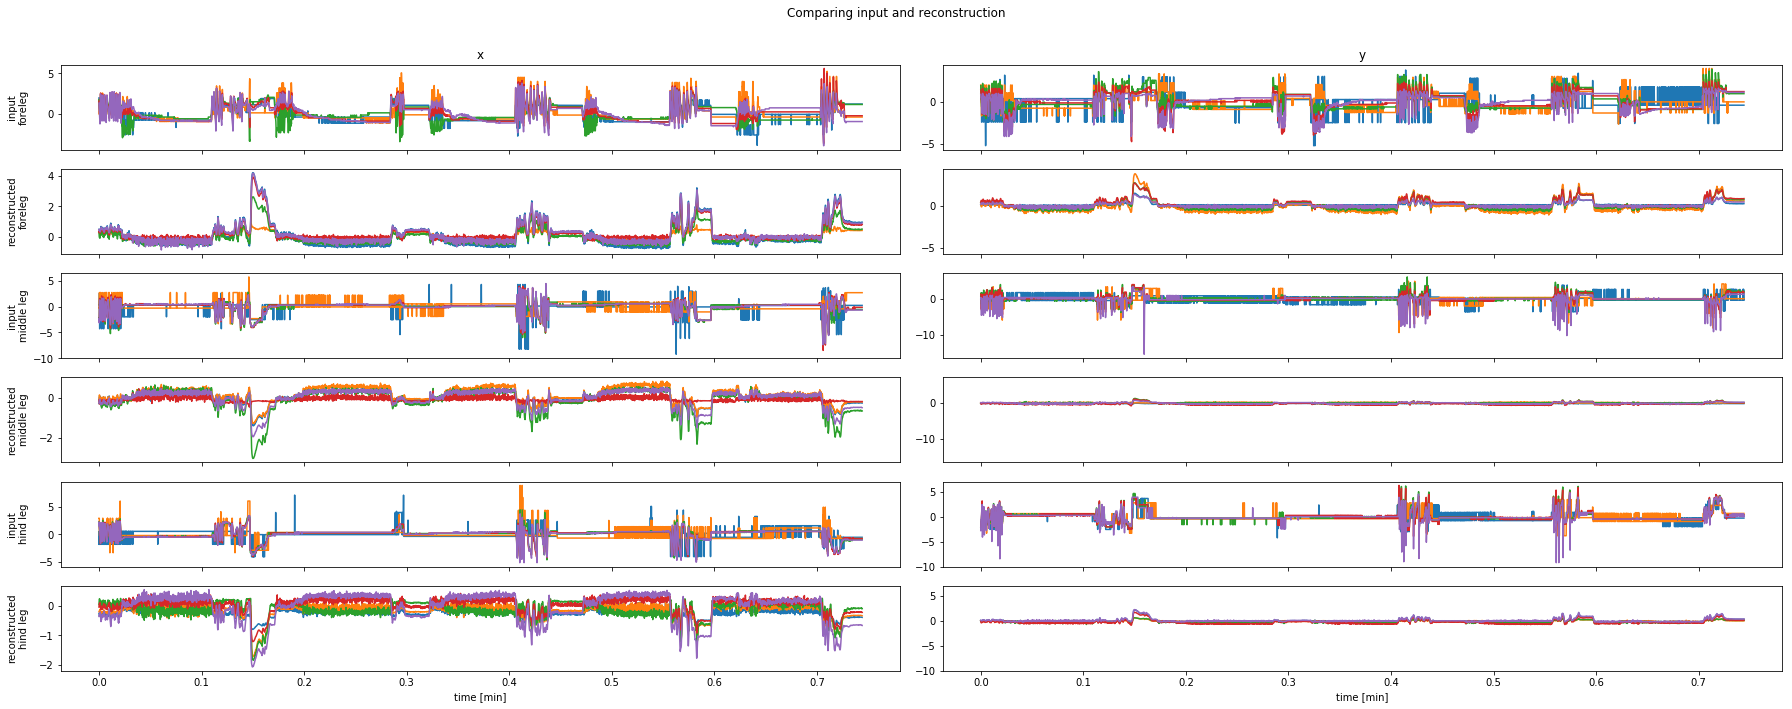

In [56]:
eval_model(vae_training_results, X, X_eval, y, y_frames, run_cfg)

In [30]:
from som_vae.losses.normalized_mutual_information import normalized_mutual_information
from som_vae.losses.purity import purity


def eval_model(training_results, X, X_eval, y, y_frames, run_config, supervised=False):
    model = training_results['model']
    #train_reports = training_results['train_report']
    #test_reports= training_results['test_report']

    exp_desc = run_config.description(short=False)
    exp_desc_short = run_config.description()
    
    if supervised:
        exp_desc_short = 'supervised' + exp_desc_short

    X_hat_eval = _reshape_and_rescale_(model(X).numpy()[back_to_single_time])
    
    if run_config['data_type'] == config.DataType.ANGLE_3D:
        plot_recon_path = plot_reconstruction_comparision_angle_3d(X_eval, X_hat_eval, 
                                                                   epochs=len(training_results['train_reports']), 
                                                                   run_desc=exp_desc_short)
    else:
        plot_recon_path = plot_reconstruction_comparision_pos_2d(X_eval, X_hat_eval, 
                                                                 epochs=len(training_results['train_reports']), 
                                                                 run_desc=exp_desc_short)

    return
                
    X_latent = get_latent_space(training_results['model'], X)
    X_latent_mean_tsne_proj = TSNE(n_components=2, random_state=42).fit_transform(np.hstack((X_latent.mean, X_latent.var)))

    cluster_assignments = HDBSCAN(min_cluster_size=8).fit_predict(np.hstack((X_latent.mean, X_latent.var)))
                                                                                      
    plot_latent_path = plot_latent_space(X_latent,
                                         X_latent_mean_tsne_proj,
                                         np.array([y.label.name for _, y in y_frames[back_to_single_time]]),
                                         cluster_assignments,
                                         exp_desc_short,
                                         epochs=len(training_results['train_reports']))
                
    group_videos = list(video.group_video_of_clusters(cluster_assignments,
                                                      y_frames[back_to_single_time],
                                                      exp_desc_short, 
                                                      epochs=len(training_results['train_reports'])))
    #nmi = normalized_mutual_information(cluster_assignments, y)
    #pur = purity(cluster_assignments, y)

    return {'latent_projection': X_latent_mean_tsne_proj, 
            'cluster_assignments': cluster_assignments,
            'plot_paths': {'reconstruction': plot_recon_path, 'latent': plot_latent_path},
            'video_paths': {'groups': group_videos},
           }

In [21]:
X = np.vstack((X_train, X_test))
y = np.vstack((y_train, y_test))
y_frames = np.vstack((frame_labels_train, frame_labels_test))

train_dataset = to_tf_data(X_train, y_train, batch_size=run_cfg['batch_size'])
test_dataset = to_tf_data(X_test, y_test, batch_size=run_cfg['batch_size']) 

if run_cfg['use_time_series']:
    back_to_single_time = np.s_[:, -1, :]
else:
    back_to_single_time = np.s_[:]
    
X_eval = _reshape_and_rescale_(X[back_to_single_time])

In [22]:
from itertools import product

def grid_search(grid_search_params, eval_steps=25, epochs=150, supervised_eval_steps=1, supervised_epochs=5):
    parameters = product(*grid_search_params.values())
    cfgs = ((p, config.RunConfig(**dict(zip(grid_search_params.keys(), p)))) for p in parameters)

    for p, cfg in cfgs:
        # this allows continuous training with a fixed number of epochs. uuuh yeah.
        # there is however a side-effect problem here. I am running this on a GPU, `init` and `train` need to be called in order.
        # it needs to be init->train, init->train, ... init resets the graph, and I guess this will free up memory
        vae_training_args = vae_training.init(input_shape=X_train.shape[1:], run_config=cfg)
        vae_training_results = {}
        eval_results = []
        for u in range(np.int(epochs / eval_steps)):
            try:
                vae_training_results = vae_training.train(**{**vae_training_args, **vae_training_results},
                                                          train_dataset=train_dataset, 
                                                          test_dataset=test_dataset,
                                                          early_stopping=False,
                                                          n_epochs=eval_steps)

                eval_results += [eval_model(vae_training_results, X, X_eval, y, y_frames, cfg)]
            except Exception as e:
                print(f"problem with {vae_training_args}: {e}")
            #for n, p in eval_results[-1]['plot_paths'].items():
            #    tf_helpers.tf_write_image(vae_training_args['test_summary_writer'], n, p, vae_training_results['train_reports'].shape[0])
        
        eval_results += [eval_model(vae_training_results, X, X_eval, y, y_frames, cfg)]
        
        #
        # Unsupervised part
        # 
        
        base_mdl = vae_training_results['model'].__class__(latent_dim=run_cfg['latent_dim'], 
                                                           input_shape=X_train.shape[1:],
                                                           batch_size=run_cfg['batch_size'])
        base_mdl.load_weights(vae_training_args['model_checkpoints_path'])

        supervised_training_args = supervised_training.init(model=base_mdl.inference_net, run_config=run_cfg)
        supervised_training_results = {}
        supervised_eval_results = []

        for u in range(np.int(epochs / eval_steps)):
            supervised_training_results = supervised_training.train(**{**supervised_training_args, **supervised_training_results},
                                                      train_dataset=train_dataset, 
                                                      test_dataset=test_dataset,
                                                      early_stopping=False,
                                                      n_epochs=eval_steps)

        base_mdl.inference_net = supervised_training_results['model']
        supervised_training_results['model'] = base_mdl 

        eval_model(supervised_training_results, X, X_eval, y, y_frames, cfg)
        
        yield p, 
        vae_training_results['train_reports'], 
        vae_training_results['test_reports'],
        vae_training_args['model_checkpoints_path'],
        eval_results,
        supervised_training_results['train_reports'],
        supervised_training_results['test_reports'],
        supervised_training_args['model_checkpoints_path']

In [23]:
grid_search_params = {
    'data_type': [config.DataType.POS_2D], # config.DataType.values(),
    'model_impl':  config.ModelType.values()
,
    'latent_dim': [12, 16]
}

if SetupConfig.runs_on_lab_server():
    started_at = datetime.now().strftime("%Y%m%d-%H%M%S")
    grid_search_results = list(grid_search(grid_search_params, eval_steps=25, epochs=100))
    dump_results(grid_search_results, f"grid_search_only_vae_{started_at}")

In [24]:
#grid_search_results = list(grid_search(grid_search_params, eval_steps=2, epochs=5))
#dump_results(grid_search_results, 'grid_search_only_vae')

In [25]:
reload(tf_helpers)
reload(vae_training)

<module 'som_vae.training.vae' from '/home/sam/proj/epfl/neural_clustering_vae/som_vae/training/vae.py'>

W0613 22:29:37.753547 140180185089856 deprecation_wrapper.py:119] From /home/sam/proj/epfl/neural_clustering_vae/som_vae/training/vae.py:25: The name tf.reset_default_graph is deprecated. Please use tf.compat.v1.reset_default_graph instead.



Using model: ModelType.SKIP_PADD_CONV


/home/sam/.local/opt/miniconda3/envs/tf_nightly/lib/python3.7/site-packages/tensorflow/python/eager/execution_callbacks.py:174: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  np.issubdtype(numpy_dtype, np.complex) or


[30 28 27 26 24 23 22 21 19 18 17 15 14 13 12]
[ 6  7  9 11 12 14 16 18 19 21 23 24 26 28 30]


W0613 22:29:41.179862 140180185089856 deprecation_wrapper.py:119] From /home/sam/proj/epfl/neural_clustering_vae/som_vae/training/vae.py:60: The name tf.train.AdamOptimizer is deprecated. Please use tf.compat.v1.train.AdamOptimizer instead.



epoch 0


W0613 22:29:42.078366 140180185089856 deprecation_wrapper.py:119] From /home/sam/proj/epfl/neural_clustering_vae/som_vae/models/drosoph_vae.py:115: The name tf.random_normal is deprecated. Please use tf.random.normal instead.

W0613 22:29:42.177170 140180185089856 deprecation_wrapper.py:119] From /home/sam/proj/epfl/neural_clustering_vae/som_vae/losses/vae_loss.py:40: The name tf.losses.mean_squared_error is deprecated. Please use tf.compat.v1.losses.mean_squared_error instead.



Epoch: 0000, train/test loss: 1.868	 3.071 took 15.251 sec


W0613 22:32:13.654585 140180185089856 _io.py:361] IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (912, 456) to (912, 464) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
W0613 22:32:15.429160 140180185089856 _io.py:361] IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (912, 456) to (912, 464) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
W0613 22:32:16.779225 140180185089856 _io.py:361] IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (912, 456) to (912, 464) to ensure video compatibility with most codecs and players. To prevent resizing, make y

epoch 7
Epoch: 0010, train/test loss: 1.397	 2.314 took 13.497 sec


W0613 22:34:53.204646 140180185089856 _io.py:361] IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (912, 456) to (912, 464) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
W0613 22:34:55.392555 140180185089856 _io.py:361] IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (912, 456) to (912, 464) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
W0613 22:34:56.487267 140180185089856 _io.py:361] IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (912, 456) to (912, 464) to ensure video compatibility with most codecs and players. To prevent resizing, make y

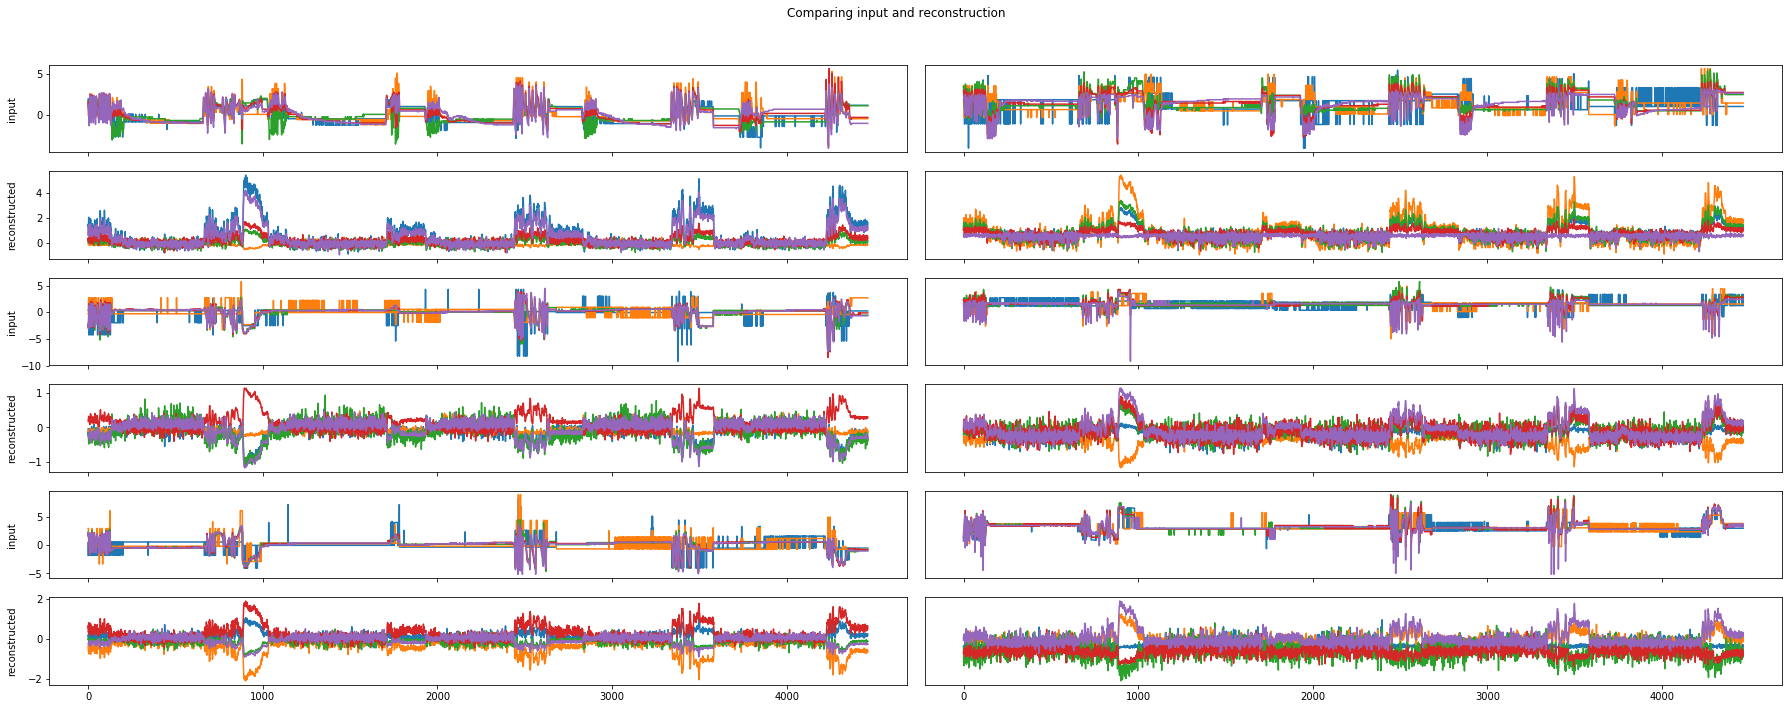

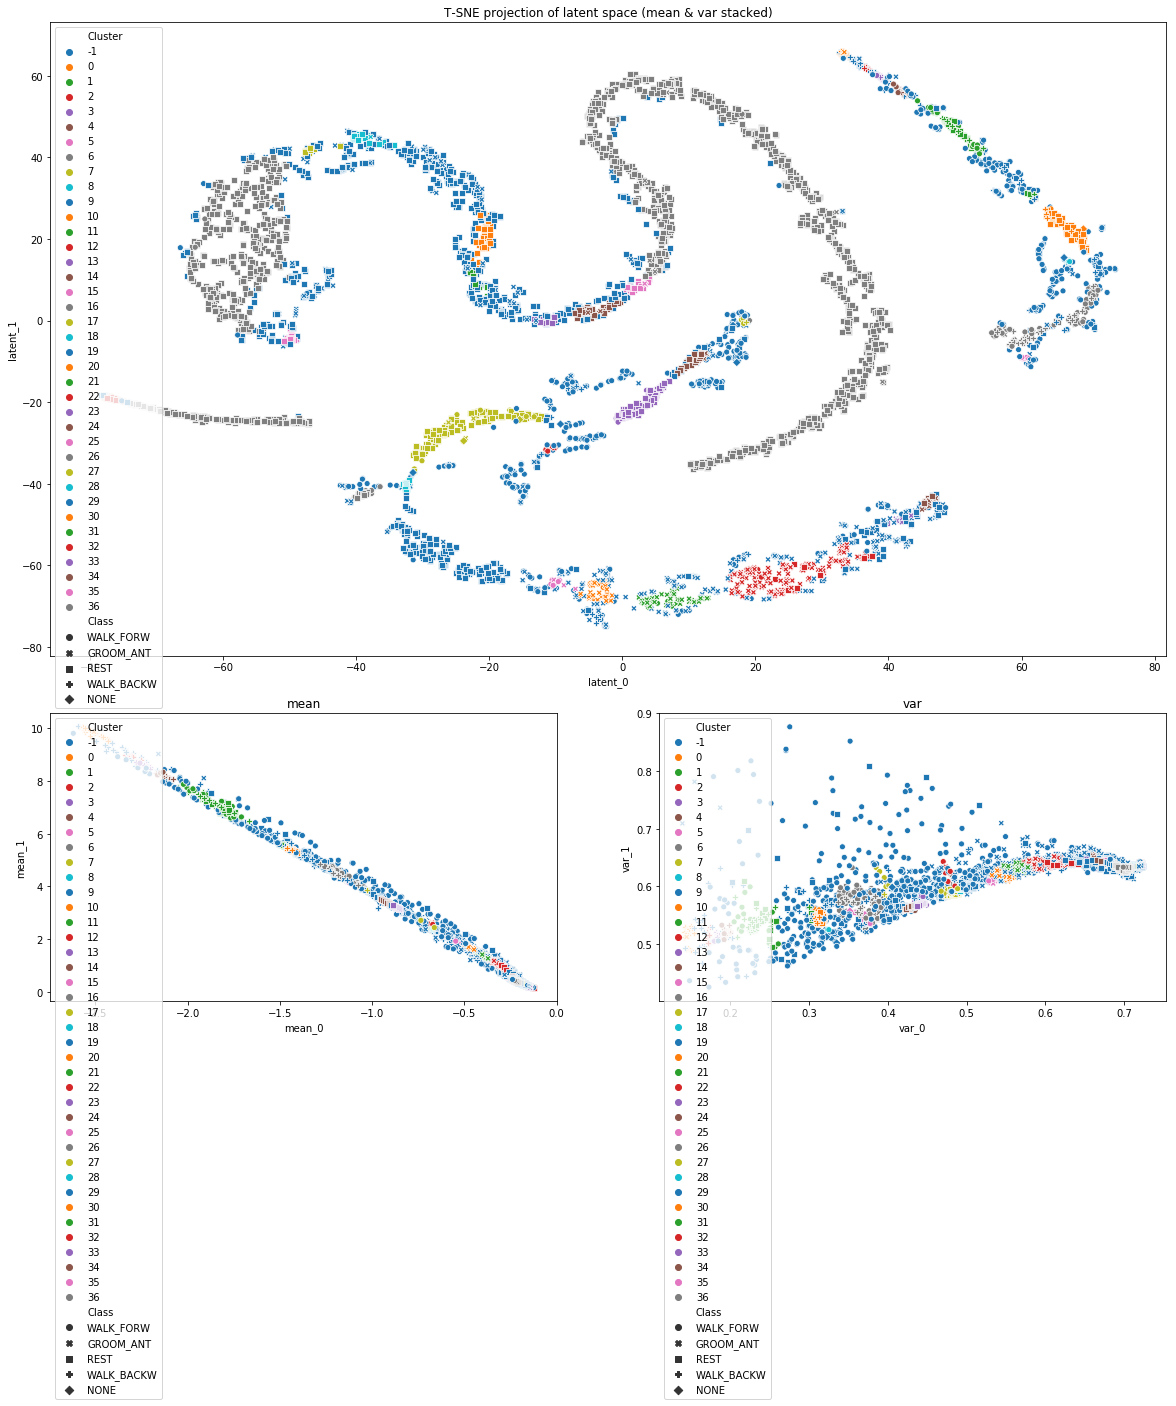

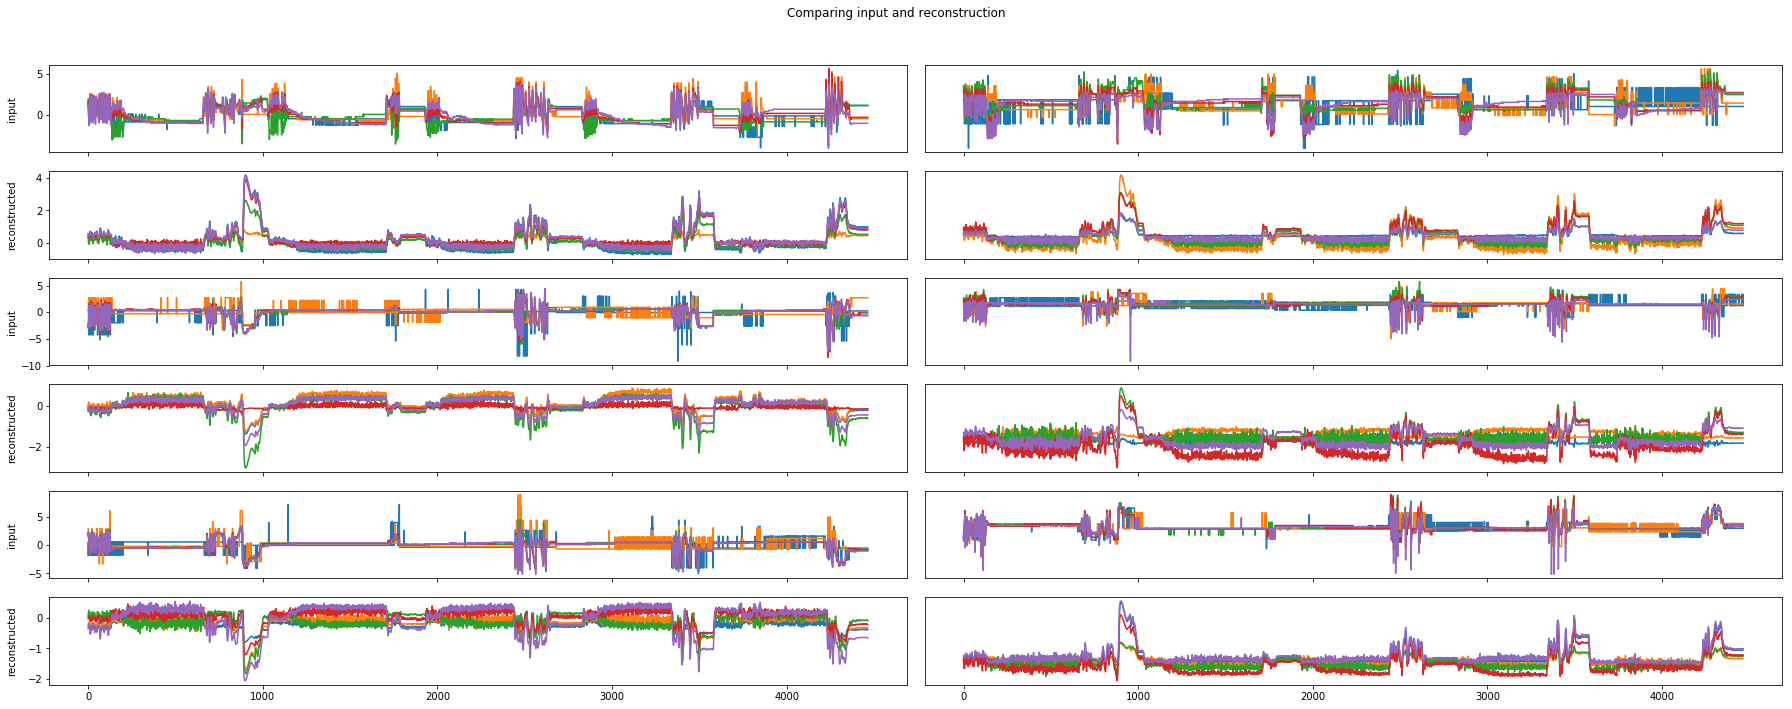

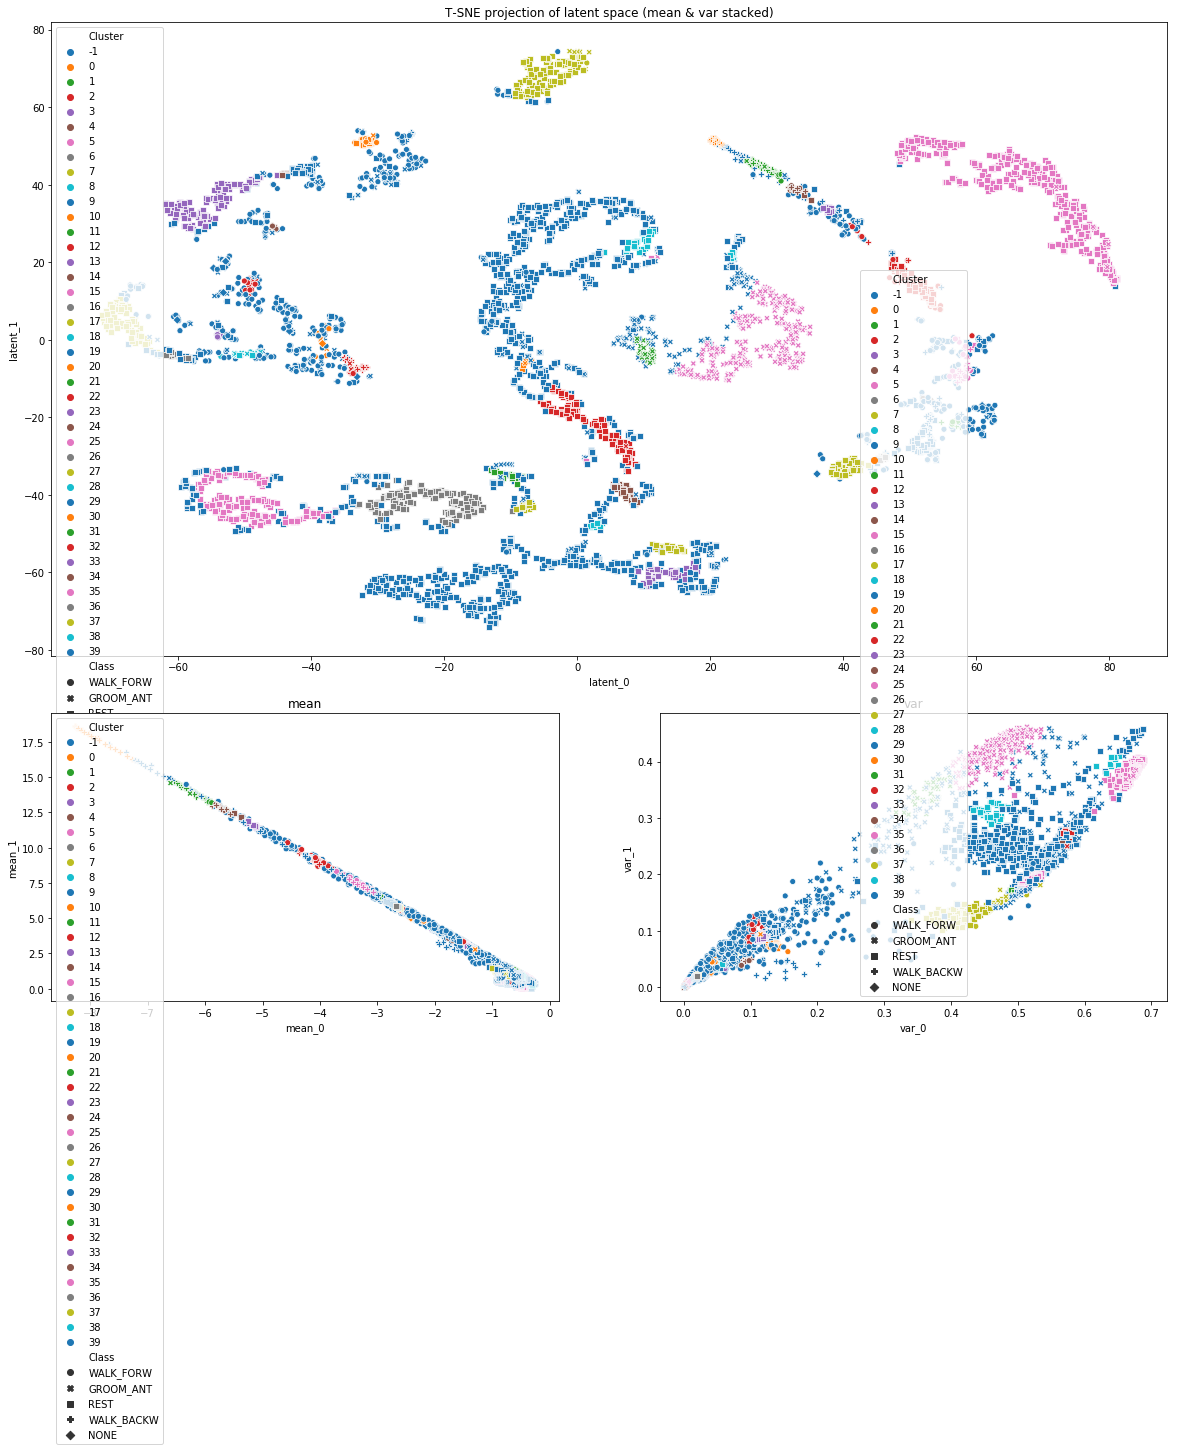

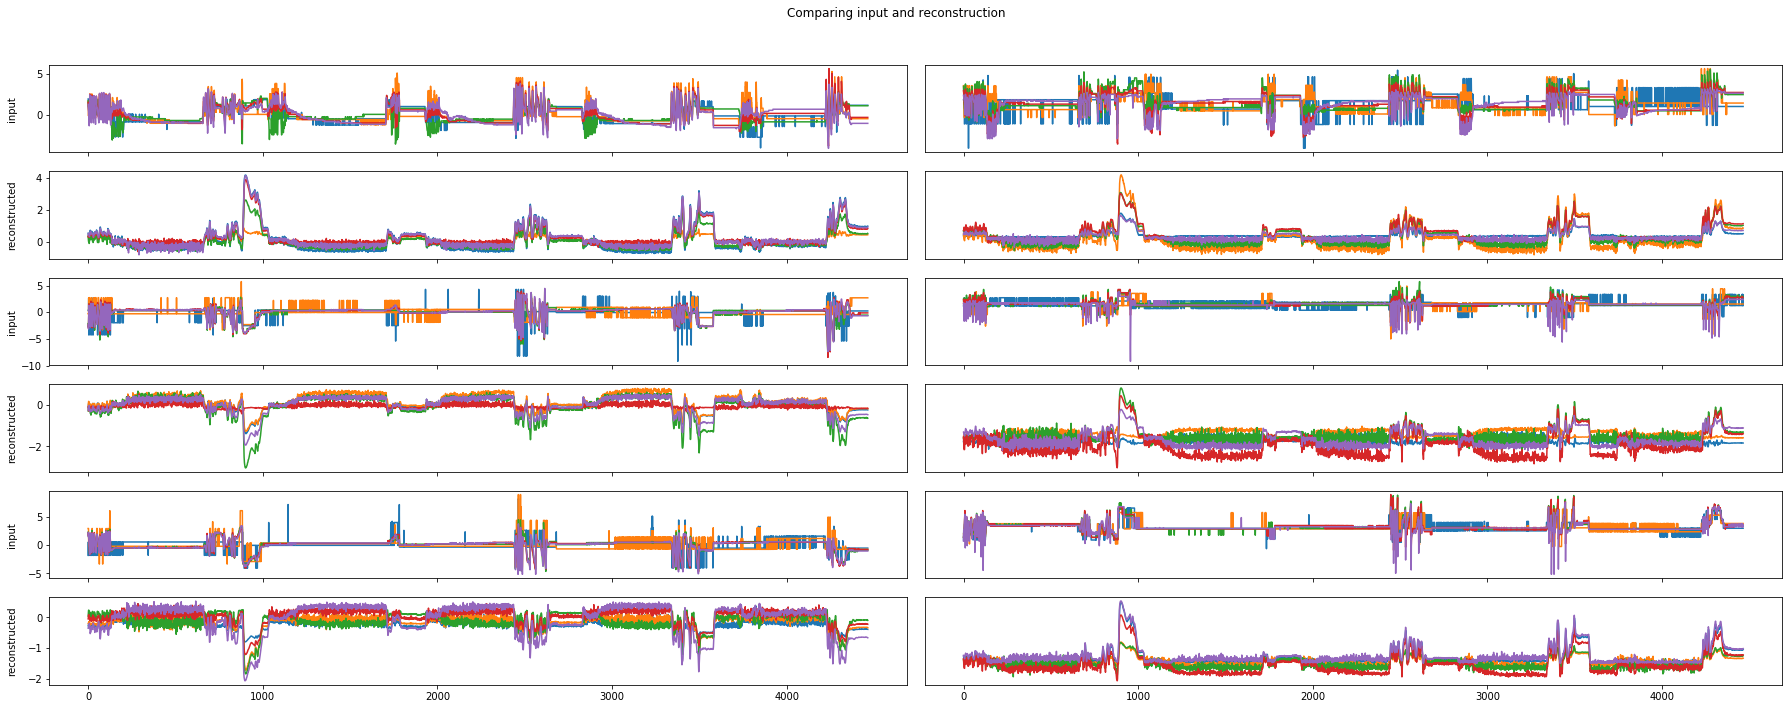

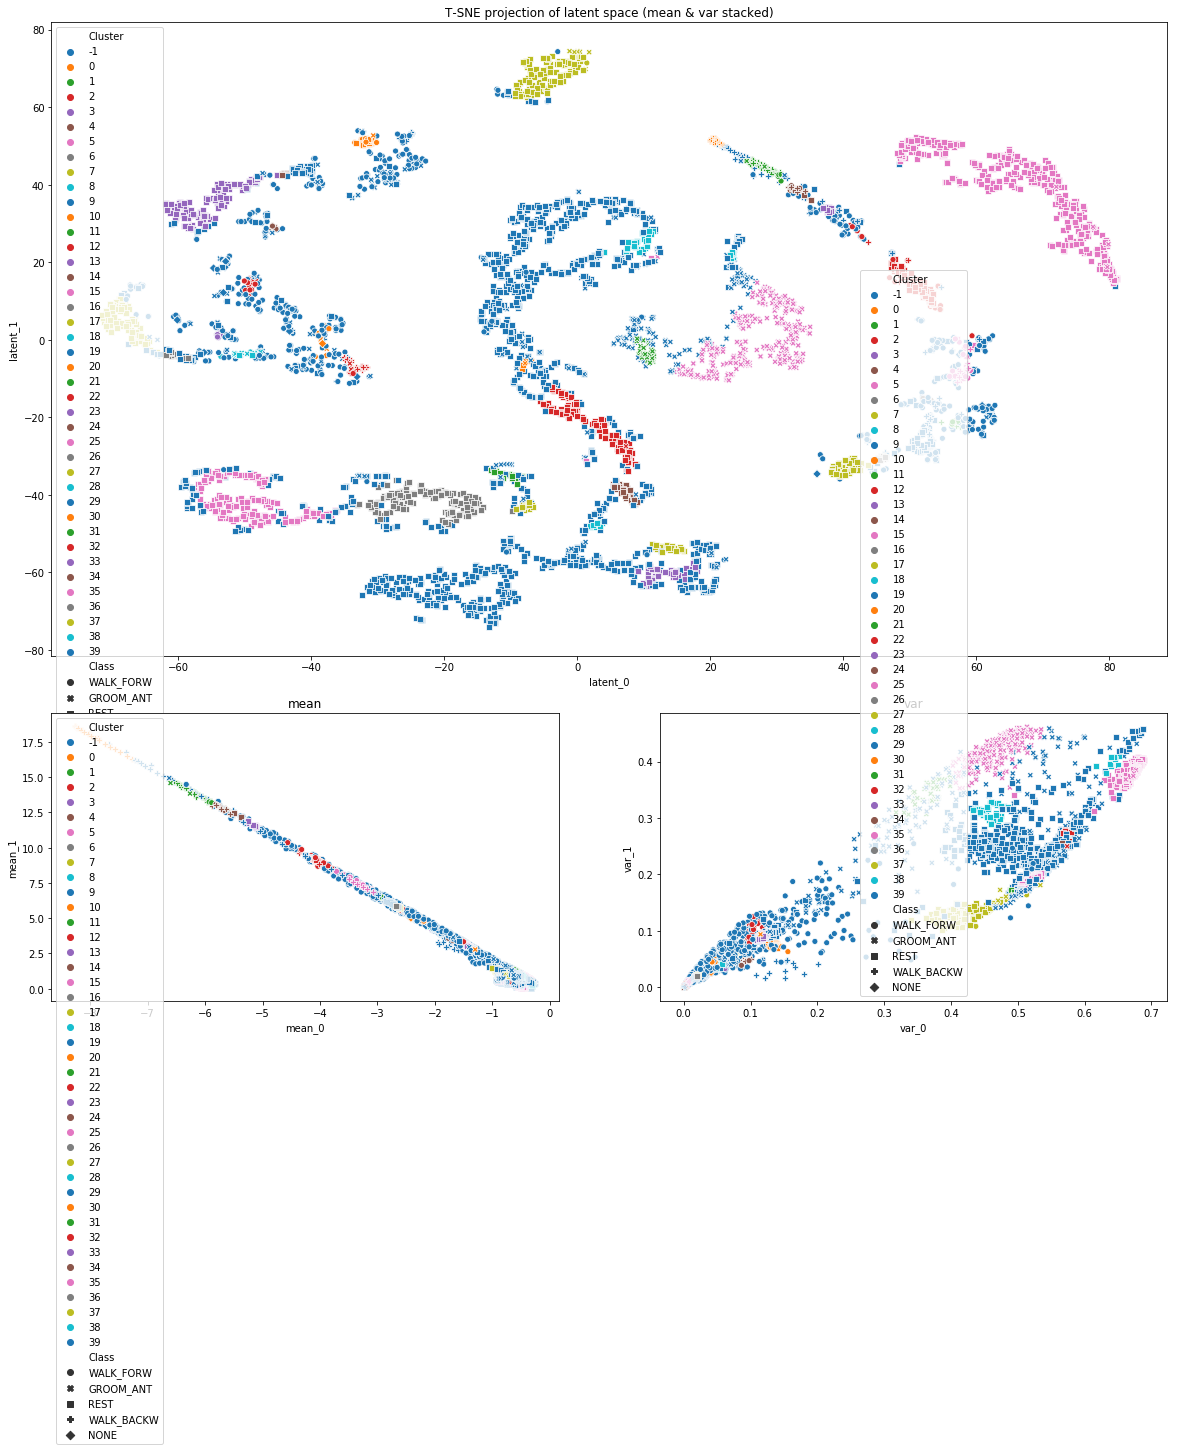

In [26]:
if not SetupConfig.runs_on_lab_server():
    reload(vae_training)
    epochs = 14
    eval_steps = 7
    run_cfg['latent_dim'] = 6
    vae_training_args = vae_training.init(input_shape=X_train.shape[1:], run_config=run_cfg)
    vae_training_results = {}
    eval_results = []
    for u in range(np.int(epochs / eval_steps)):
        vae_training_results = vae_training.train(**{**vae_training_args, **vae_training_results},
                                                  train_dataset=train_dataset, 
                                                  test_dataset=test_dataset,
                                                  early_stopping=False,
                                                  n_epochs=eval_steps)

        eval_results += [eval_model(vae_training_results, X, X_eval, y, y_frames, run_cfg)]

    eval_results += [eval_model(vae_training_results, X, X_eval, y, y_frames, run_cfg)]

In [27]:
eval_results

[{'latent_projection': array([[-25.637442 , -35.456394 ],
         [ -6.9283695, -15.826792 ],
         [  0.2879823, -13.628143 ],
         ...,
         [  5.5368133, -16.417067 ],
         [  5.9191203, -15.802441 ],
         [  6.3187733, -15.375858 ]], dtype=float32),
  'cluster_assignments': array([-1,  9, -1, ..., 13, 13, 13]),
  'plot_paths': {'reconstruction': '/home/sam/proj/epfl/neural_clustering_data/figures/SKIP_PADD_CONV-POS_2D-t-16-ld-6_20190613-222941_e-7_input_gen_recon_comparision.png',
   'latent': '/home/sam/proj/epfl/neural_clustering_data/figures/SKIP_PADD_CONV-POS_2D-t-16-ld-6_20190613-222941_e-7_latent_space_tsne.png'},
  'video_paths': {'groups': [(36,
     '/home/sam/proj/epfl/neural_clustering_data/videos/group_of_cluster-36-SKIP_PADD_CONV-POS_2D-t-16-ld-6_20190613-222941-e-7.mp4'),
    (19,
     '/home/sam/proj/epfl/neural_clustering_data/videos/group_of_cluster-19-SKIP_PADD_CONV-POS_2D-t-16-ld-6_20190613-222941-e-7.mp4'),
    (17,
     '/home/sam/proj/epfl/

In [ ]:
eval_model(vae_training_results, X, X_eval, y, y_frames, run_cfg)

In [28]:
stop

NameError: name 'stop' is not defined

# evaluation

In [ ]:
#if run_cfg['data_type'] == config.DataType.POS_2D:
#    fig = plots.plot_comparing_joint_position_with_reconstructed(X_eval,
#                                                                 X_hat_eval,
#                                                                 X_gen_eval,
#                                                                 validation_cut_off=n_train_data_points,
#                                                                 exp_desc=exp_desc_short);
#else:
#    # ncols is an ugly hack... it works on the basis that we have three working angles for each leg
#    if run_cfg['use_single_fly']:
#        start = 0
#        end = len(X_eval)
#    else:
#        start = 100
#        end = 1000
#    xticks = np.arange(start, end) / SetupConfig.value('frames_per_second') / 60.
#    if run_cfg['debug']:
#        _input_data = X[:, :, 0]
#        _recon = model(X, apply_sigmoid=False).numpy()[:, :, 0]
#        fig, axs = plt.subplots(nrows=_input_data.shape[-1], ncols=1, figsize=(20, 30), sharex=True, sharey=True)
#        for i in range(_input_data.shape[-1]):
#            _idx_ = np.s_[start:end, i]
#            axs[i].plot(xticks, _input_data[_idx_], label='input')
#            axs[i].plot(xticks, _recon[_idx_], label='reconstructed')
#    else:
#        fig, axs = plt.subplots(nrows=X_eval.shape[1], ncols=1, figsize=(20, 30), sharex=True, sharey=True)
#        for i, cn in enumerate(SD.get_3d_columns_names(selected_cols)):
#            _idx_ = np.s_[start:end, i]
#            axs[i].plot(xticks, X_eval[_idx_], label='input')
#            axs[i].plot(xticks, reconstructed_data[_idx_], label='reconstructed')
#
#            axs[i].set_title(cn)
#
#    axs[-1].set_xlabel('time [min]')
#    axs[0].legend(loc='upper left')
#    
#    #plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
#    plt.suptitle(f"Comparision of selection of data\n({exp_desc})")
#    
#    plt.tight_layout()
#    plt.subplots_adjust(top=0.94)
#    plt.savefig(f"./figures/{exp_desc_short}_input_gen_recon_comparision.png")

# Latent space

In [ ]:
#plot_latent_space(X_latent, X_latent_mean_tsne_proj, y, run_cfg, epochs=len(vae_training_results['train_reports']))

In [ ]:
#from matplotlib.collections import LineCollection
#
#def plot_debug(input_data, cluster_assignments, cluster_colors=None):
#    _clusters = np.unique(cluster_assignments)
#    _colors = sns.color_palette(n_colors=len(_clusters))
#    if cluster_colors is None:
#        cluster_colors = dict(zip(_clusters, _colors))
#        
#    lines, colors = zip(*[([(x, input_data[x, 0]) for x in segment], cluster_colors[cluster_id])
#                           for cluster_id, segments in video.group_by_cluster(cluster_assignments).items() 
#                           for segment in segments])
#
#
#    
#    fig, ax = plt.subplots(figsize=(10, 8))
#    coll = LineCollection(lines, colors=colors)
#    #coll.set_array(np.random.random(xy.shape[0]))
#
#    ax.add_collection(coll)
#    ax.autoscale_view()
#
#    plt.title('Input data and cluster assigment using debug data');
#    
#if run_cfg['debug']:
#    plot_debug(input_data, cluster_assignments)

In [ ]:
# TODO
# use this to add a different shape to the scatter plot
# frames_idx_with_labels[:len(frames_of_interest)][frames_of_interest][run_config['time_series_length'] - 1:]['label'].apply(lambda x: x.value)

# videos

In [ ]:
#cluster_assignments = eval_results[-1]['cluster_assignments']
#
#group_videos = list(video.group_video_of_clusters(cluster_assignments, y_frames[back_to_single_time], run_cfg))

In [ ]:
display_video(eval_results[-1]['video_paths']['groups'][0][1])

In [ ]:
reload(video)

In [ ]:
X_train.shape

In [ ]:
X.shape

In [ ]:
frame_labels

In [ ]:
len(group_videos)

In [ ]:
#idx = 0
idx += 1
display_video(group_videos[idx][1])

In [ ]:
stop

In [ ]:

#new_im.save('test.jpg')

In [ ]:
def reverse_pos_pipeline(x, normalisation_factors):
    """TODO This is again pretty shitty... ultra hidden global variable"""
    return x + normalisation_factors[:x.shape[-1]]

def video_prep_raw_data(data):
    if run_config['use_time_series']:
        return reverse_pos_pipeline(scaler.inverse_transform(data[:, -1, :]).reshape(-1, 15, 2))
    else:
        return reverse_pos_pipeline(scaler.inverse_transform(data.reshape(-1, 30)).reshape(-1, 15, 2))
    
def video_prep_recon_data(input_data):
    return reverse_pos_pipeline(scaler.inverse_transform(model(input_data).numpy()).reshape(-1, 15, 2))

In [ ]:
if run_config['data_type'] == _DATA_TYPE_2D_POS_:
    _positional_data_ = [reverse_pos_pipeline(input_data, normalisation_factors=normalisation_factors), 
                         reverse_pos_pipeline(reconstructed_data, normalisation_factors=normalisation_factors)]
else:
    raise NotImplementedError('give me a break')
    
p = video.comparision_video_of_reconstruction(_positional_data_,
                                              images_paths_for_experiments=images_paths_for_experiments, 
                                              n_train=len(data_train),
                                              cluster_assignments=cluster_assignments,
                                              as_frames=False,
                                              exp_desc=exp_desc_short)

display_video(p)

In [ ]:
# Super ugly... but necessary...
# first there is the time offset due to the slicing
# then there is the concatenation of the data...

angle_data_pos_to_frame = []

for exp_key, data in angle_data_raw: 
    _exp = SD._experiment_from_key_(exp_key)
    
    if len(angle_data_pos_to_frame) == 0:
        _idx = np.arange(data.shape[0])[run_config['time_series_length'] - 1:]
    else:
        _idx = np.arange(data.shape[0])# + len(angle_data_pos_to_frame)
        
    angle_data_pos_to_frame += [(_exp, d) for d in _idx]

In [ ]:
        images_paths_for_experiments = settings.data.EXPERIMENTS.map(lambda x: (x, config.positional_data(x)))\
                                               .flat_map(lambda x: [(x[0], config.get_path_for_image(x[0], i)) for i in range(x[1].shape[1])])\
                                               .to_list()

In [ ]:

    frames_idx_with_labels = preprocessing.get_frames_with_idx_and_labels(settings.data.LABELLED_DATA)
    frames_of_interest = ~frames_idx_with_labels['label'].isin([settings.data._BehaviorLabel_.REST])

In [ ]:
images_paths_for_experiments = [(exp, config.get_path_for_image(exp, i)) for exp, i in angle_data_pos_to_frame]

In [ ]:
images_paths_for_experiments[-10:]

In [ ]:
reload(video)
from collections import OrderedDict
_N_CLUSTER_TO_VIZ_ = 10
_t = [(misc.flatten(sequences), cluster_id) for cluster_id, sequences in video.group_by_cluster(cluster_assignments).items()]
_t = sorted(_t, key=lambda x: len(x[0]), reverse=True)

cluster_colors = sns.color_palette(n_colors=len(np.unique(cluster_assignments)))

cluster_vids = OrderedDict((p[1], video.comparision_video_of_reconstruction(input_data,
                                                                            cluster_assignments=cluster_assignments,
                                                                            images_paths_for_experiments=images_paths_for_experiments,
                                                                            n_train=data_train.shape[0],
                                                                            cluster_colors=cluster_colors,
                                                                            cluster_id_to_visualize=p[1], 
                                                                            exp_desc=exp_desc_short,
                                                                            is_2d=False))
                    for p in _t[:_N_CLUSTER_TO_VIZ_])

print('cluster_vids: ', cluster_vids.keys())

In [ ]:
! cat ./som_vae/helpers/video.py

In [ ]:
from collections import OrderedDict
_N_CLUSTER_TO_VIZ_ = 10
_t = [(misc.flatten(sequences), cluster_id) for cluster_id, sequences in video.group_by_cluster(cluster_assignments).items()]
_t = sorted(_t, key=lambda x: len(x[0]), reverse=True)

cluster_colors = sns.color_palette(n_colors=len(np.unique(cluster_assignments)))

cluster_vids = OrderedDict((p[1], video.comparision_video_of_reconstruction(_positional_data_,
                                                                      cluster_assignments=cluster_assignments,
                                                                      images_paths_for_experiments=images_paths_for_experiments,
                                                                      n_train=data_train.shape[0],
                                                                      cluster_colors=cluster_colors,
                                                                      cluster_id_to_visualize=p[1], exp_desc=exp_desc_short))
                    for p in _t[:_N_CLUSTER_TO_VIZ_])

print('cluster_vids: ', cluster_vids.keys())

In [ ]:
#c_idx = 0
c_idx += 1
display_video(list(cluster_vids.values())[c_idx])

In [ ]:
c_idx = 0
#c_idx += 1
display_video(list(cluster_vids.values())[c_idx])

In [ ]:
images_paths_for_experiments

In [ ]:
len(np.where(cluster_assignments == 11)[0])

In [ ]:
np.array(images_paths_for_experiments)

In [ ]:
for fs, c in _t:
    print(f"cluster {c} has {len(fs)} elements")

In [ ]:
reload(video)

_t = [(misc.flatten(sequences), cluster_id) for cluster_id, sequences in video.group_by_cluster(cluster_assignments).items()]
_t = sorted(_t, key=lambda x: len(x[0]), reverse=True)
p = video.video_angle(cluster_assignments, images_paths_for_experiments, cluster_id_to_visualize=_t[3][1], exp_desc=exp_desc_short)

In [ ]:
display_video(p)

In [ ]:
stop

# Convolution Clarification

Below are the results shown for a Conv1d for all padding options:

- valid: only convolutions where the kernel fits inside the input are comptued
- causal: input is shifted such that the kernel can only see itself and backwards in time
- same: input is padded such that the convolution can also be applied to the border cases

kernel sizes of 2 & 3, and dilation rates for 1 to 3.

The result is that a valid convolution of kernel size 2 with a dilation factor of 1 compresses the input in a for us good way.
The data goes from `[batch_size, n_time_steps, n_channels]` to `[batch_size, n_time_steps - 1, n_filters]` 
and crops the first time step only. Thus building features by only looking backwards in time,
dropping the first-time step. Thus features are build over time and space.

In [ ]:
example_data = np.zeros((1, 10, 5), dtype=np.float32)

for row in range(example_data.shape[1]):
    example_data[:, row, :] = row
    
example_data

In [ ]:
def conv_clarification_kernel(kernel_size):
    conv1d_kernel_no_time = np.zeros((kernel_size, example_data.shape[-1], 1), dtype=np.float32)
    conv1d_kernel_no_time[0, :, :] = .5
    conv1d_kernel_no_time[1, :, :] = 1.
    
    if kernel_size == 3:
        conv1d_kernel_no_time[2, :, :] = 0.1
    
    return conv1d_kernel_no_time


for kernel_size in range(2, 4):
    print(f"data\n{example_data}")
    print(f"kernel\n{conv_clarification_kernel(kernel_size)}")
    for padding in ['valid', 'causal', 'same']:
        for dilation in range(1, 4):
            example_conv1d = tfkl.Conv1D(filters=1, 
                                         kernel_size=kernel_size,
                                         use_bias=False, 
                                         padding=padding,
                                         dilation_rate=dilation,
                                         kernel_initializer=tf.constant_initializer(conv_clarification_kernel(kernel_size)))

            conv_res = example_conv1d(example_data).numpy()
            print(f"padding: {padding}, dilation_rate: {dilation}, kernel_size: {kernel_size}, output shape: {conv_res.shape}\n{conv_res}")

In [ ]:
def conv_clarification_kernel(kernel_size):
    conv1d_kernel_no_time = np.zeros((kernel_size, example_data.shape[-1], example_conv1d_n_filters), dtype=np.float32)
    conv1d_kernel_no_time[0, :, :] = .5
    conv1d_kernel_no_time[1, :, :] = 1.
    
    if kernel_size == 3:
        conv1d_kernel_no_time[2, :, :] = 0.1
    
    return conv1d_kernel_no_time

kernel_size = 2
padding = 'valid'
dilation_rate = 1
example_conv1d_n_filters = 2

print(f"data\n{example_data}")
print(f"kernel\n{conv_clarification_kernel(kernel_size)}")
example_conv1d = tfkl.Conv1D(filters=example_conv1d_n_filters, 
                             kernel_size=kernel_size,
                             use_bias=False, 
                             padding=padding,
                             dilation_rate=dilation_rate,
                             kernel_initializer=tf.constant_initializer(conv_clarification_kernel(kernel_size)))

example_max_pooling_layer = tfkl.MaxPool1D()
example_dense = tfkl.Dense(2, use_bias=False, kernel_initializer='ones')

conv_res = example_conv1d(example_data[:,:2,:]).numpy()
#max_pool_res = example_max_pooling_layer(conv_res)
#dense_res = example_dense(max_pool_res)
print(f"padding: {padding}, dilation_rate: {dilation_rate}, kernel_size: {kernel_size}, output shape: {conv_res.shape}")
print('conv\n', conv_res)
#print('max pool\n', max_pool_res.numpy())
#print('dense\n', dense_res.numpy())

In [ ]:
conv_res

In [ ]:
class Conv1D_Transpose(tfkl.Layer):
    def __init__(self, n_filters, kernel_size, batch_size):
        super(Conv1D_Transpose, self).__init__()        
        self.n_filters = n_filters
        self.batch_size = batch_size
        self.conv2d_transpose = tfkl.Conv2DTranspose(filters=n_filters, kernel_size=kernel_size, strides=2, padding='valid', kernel_initializer='ones')
        
    def call(self, inputs):
        x = tf.reshape(inputs, [self.batch_size, 1, *inputs.shape[1:]])
        print(x.shape)
        x = self.conv2d_transpose(x)
        #x = tf.reshape(x, [self.batch_size, -1, self.n_filters])
        
        return x

example_deconv1d = Conv1D_Transpose(n_filters=2, kernel_size=2, batch_size=1)
example_deconv1d(conv_res)

In [ ]:
_ted = example_deconv1d(conv_res)
tf.reshape(_ted, _ted.shape[:-1])

In [ ]:
UpsamplingConv(2)(conv_res)

In [ ]:
tfkl.UpSampling1D(3)(conv_res)

In [ ]:
class UpsamplingConv(tfkl.Layer):
    def __init__(self, n_filters, kernel_size=2):
        super(UpsamplingConv, self).__init__()
        
        self.n_filters = n_filters
        self.kernel_size = kernel_size
    
    def call(self, x): 
        x = tfkl.UpSampling1D(3)(x) # upscale with 3 so that we can again apply `valid` padding and "reverse" the encoder
        print(x.shape)
        # TODO maybe add some fancy flipping of the input
        x = tfkl.Conv1D(self.n_filters, self.kernel_size, padding='valid')(x)
        
        return x

In [ ]:
conv_res.shape

In [ ]:
conv_res

In [ ]:
example_deconv = tfkl.Conv2DTranspose(1, 2, kernel_initializer='ones')
example_deconv(conv_res.reshape(-1, 1, *conv_res.shape[1:])).numpy().reshape(-1, *conv_res.shape[1:])

In [ ]:
conv_res

In [ ]:
conv_res.shape

In [ ]:
conv_res

In [ ]:
tf.rank(conv_res)

In [ ]:
paddings = [[r, 0] for r in range(3)]
paddings

In [ ]:
tf.pad(conv_res, [[0, 0], [0, 1], [0, 0]])

In [ ]:
tfc.nn.conv1d_transpose(input=conv_res, filters=np.ones((2, 2, 2), dtype=np.float32), output_shape=[1, 2, 2], strides=1, padding='VALID')

In [ ]:
_pdc1dt = PaddedConv1dTransposed(n_filters=2)
print(conv_res.shape)
resc1 = _pdc1dt(conv_res)
print(resc1.shape)
resc1.numpy()

In [ ]:
_pdc1dt(_pdc1dt(resc1))

In [ ]:
#_t_layer_sizes_generative=[4,6,8,10,12,14,16,18]
#_t_layer_sizes_generative=[1] * 6
#_t_upsampling_size = [4] * 6 #, 2, 2]
#_t_strides = [2] * 6
##_t_padding = ['valid', 'valid', 'same']
##_t_layer_sizes_generative=[4, 8, 16]
#_latent_dim = 2
#_t_generative_net = tf.keras.Sequential([tfkl.InputLayer(input_shape=(_latent_dim,)),
#                                           tfkl.Lambda(lambda x: tf.reshape(x, [1000, 1, _latent_dim])),
#                                           *[TemporalUpsamplingConv(conv_n_filters=fs, 
#                                                                    upsampling_size=us,
#                                                                    conv_strides=s,
#                                                                    conv_padding='valid',
#                                                                    name=f"gen_conv_{i}") for i, (fs, us, s) 
#                                             in enumerate(zip(_t_layer_sizes_generative,
#                                                              _t_upsampling_size,
#                                                              _t_strides,
#                                                             ))]],
#                                          name='generative_net')
#
#_t_generative_net.summary()